* Blog post URL: https://clairesarraille.github.io/2021/08/08/kings_county_housing.html


In [1]:
import numpy as np
from scipy import stats
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import datetime as dt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline


/Users/clairesarraille/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## CRISP-DM -- CRoss Industry Standard Process for Data Mining
- Following this process ensures that the requirements and organization of formal hypothesis testing are met (broadly speaking, an iterative approach to modeling)
- Not every step was necessary, or was in scope for this particular exercise. 
----------
- Business Understanding
    - Who will be  using the model
    - How will the model be used
    - How will using the model help our business
    - clarify requirements
    - What problems are in and out of scope

- Understand Data
    - What is target
    - What are predictors
    - Distribution of Data
    - How many observations - and is this a small, medium or large collection?
    - What is the quality? - What errors could be in the data, or inaccuracy?

- Data Preparation - Prepping to model
    - Missing values
    - Type conversions
    - Remove multicollinearity (correlated predictors)
    - Standardize numeric data
    - Convert categorical data to numeric via one-hot encoding

- Modeling:
    - Tune models to get the highest performance possible on our task
    - Considerations:
        - What kind of task? Classification task? Regression task?
        - Which models will we use
        - Will we use regularization?
        - How will we validate our model?
        - Loss functions?
        - What is the performance threshold for success?

- Evaluation:
    - Does the model solve business problem outlined in step 1?
    - At this point, we may want to start over at the business understanding step, now that we have a deeper understanding
    - Things we may learn at this stage:
        - Need different data
        - Need more data
        - Should be going in a different direction
        - Should use classificaion rather than regression, or vice versa
        - Use different approach

- Deployment:
    - Move the model into production
    - Set up ETL - how much of preprocessing and cleaning can be automated?


# BUSINESS UNDERSTANDING
- Who will be  using the model?
    - The hypothetical real estate agency I work for
    - Our clients are typically people trying to sell their family home - this business case is not for apartment buildings or hotel real estate
- How will the model be used?
    - It will help us understand which variables (number of bedrooms, square footage) contribute the most to a positive increase in home selling price
- How will using the model help our business?
    - It will provide the evidence we need to give data-driven advice to our clients
    - Helping our clients make decisions to maximize selling price will increase our commissions 
    - We also have the option of charging our clients for a home-renovation consultation which would include access to the data from our model
- Clarify Requirements:
    - Coefficients for each independent variable: these coefficients represent the dollar amount impact on selling price associated with a one-unit increase of a given variable.
- What problems are in and out of scope?
    - In scope: How do home renovations impact the selling price of a home.
    - Out of scope: What selling price the model would predict given new data (data we haven't seen yet) 

# UNDERSTAND DATA
- What is **target**
>'price'
- What are **predictors**
>'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built'
- Distribution of Data - See section "DISTRIBUTIONS" 
- How many observations - and is this a small, medium or large collection?
    - 21,597 entries
    - According to Frank Harrell in his book Regression Modeling Strategies, you need at least 10-20 observations per predictor
    - We have many, many more observations than 20 * (6 - num covariates) = 120
    - Our dataset would be considered large
- What is the quality? - What errors could be in the data, or inaccuracy? - See section "Data Quality" 

## Read in Data

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

## Remove Features
- view ( has been viewed, this wouldn't help us predict prices) 
- Note: **sqft_above + sqft_basement = sqft_living**, according to meta-data:
    - sqft_above (is redundant -- repeats sqft_living)
    - sqft_basement (is redundant -- repeats sqft_living)
- sqft_living15 (is redundant - repeats sqft_living)
- sqft_lot15 (is redundant - repeats sqft_lot)
- yr_renovated (~18% of values are NULL - imputing (making educated guess) for those values is out of scope for this project, so we'll drop this field)

In [3]:
# Why reduce features?
# I narrowed my list of features to avoid over-fit of the training dataset
# Reducing redundancy in features increases the accuracy of the model
# Note: The brief for this project also recommended dropping these features.
# Dropping yr_renovated because there are 3,842 nulls in that field
# View is "has been viewed"

df = df.drop(['view', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'yr_renovated'], axis=1)

In [4]:
# Note: sqft_living includes a finished basement, if present
# Grade is the construction quality of improvements, according to a King County grading system
# Condition is overall condition of house
df.columns.sort_values()

Index(['bathrooms', 'bedrooms', 'condition', 'date', 'floors', 'grade', 'id',
       'lat', 'long', 'price', 'sqft_living', 'sqft_lot', 'waterfront',
       'yr_built', 'zipcode'],
      dtype='object')

## Data Quality

- There could be outliers - such as hundreds of bathrooms -- this wouldn't make sense considering a given home's square-footage 
- Year could be in the future
- price could be a negative number
- datatype could be wrong - such as string for number of bedrooms

### Waterfront Missing Values

In [5]:
# Waterfront is our only variable containing NULL values:
df.isnull().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
zipcode           0
lat               0
long              0
dtype: int64

- I filled in NaN values for 'waterfront' with 0. Now, 'waterfront' has a 1 value if there is a view, and 0 value if there is not.
- I also cast this column as an integer type since there are no other options besides the integers 1 and 0.

In [7]:
# Note: waterfront is our only categorical value.
# We don't need to use dummy coding or any other coding system because it's already dichotomous (1 or 0) 
df['waterfront'] = df['waterfront'].fillna(0)
df['waterfront'] = df['waterfront'].astype(int)
df['waterfront'].unique()

array([0, 1])

## Cast Features -- at a Different Scale for Visualization 

In [8]:
# Create lot size in acres:
df['acres_lot'] = df['sqft_lot'] / 43560

In [9]:
# Create price column in millions:
df['price_millions'] = df['price'] / 1000000

In [10]:
df[['price_millions','price', 'acres_lot']]

,price_millions,price,acres_lot
0,0.221900,221900.0,0.129706
1,0.538000,538000.0,0.166253
2,0.180000,180000.0,0.229568
3,0.604000,604000.0,0.114784
4,0.510000,510000.0,0.185491
...,...,...,...
21592,0.360000,360000.0,0.025964
21593,0.400000,400000.0,0.133448
21594,0.402101,402101.0,0.030992
21595,0.400000,400000.0,0.054821


# FEATURE ENGINEERING & DISTRIBUTIONS

## Clarify Grade and Condition Columns

### King County's Grading System for Buildings:
#### Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1. Falls short of minimum building standards. Normally cabin or inferior structure.

2. Falls short of minimum building standards. Normally cabin or inferior structure.

3. Falls short of minimum building standards. Normally cabin or inferior structure.

4. Generally older, low quality construction. Does not meet code.

5. Low construction costs and workmanship. Small, simple design.

6. Lowest grade currently meeting building code. Low quality materials and simple designs.

7. Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8. Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9. Better architectural design with extra interior and exterior design and quality.

10. Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11. Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12. Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13. Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

### King County's Condition Scale: 
#### Relative to age and grade. Coded 1-5.

1. Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2. Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3. Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4. Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5. Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

## Create New Columns from Date Sold
- The date column is the date home was sold
- If we convert this date to a numerical value, the origin would be year 0 -- and this would be difficult to interpret for our study
- Instead, I'll extract the year from the date column, and create a new feature using year_built to get age_sold (in years)

In [11]:
# This means the datatype of the date column is an object
df.date.dtype

dtype('O')

In [12]:
df[['date']]

,date
0,10/13/2014
1,12/9/2014
2,2/25/2015
3,12/9/2014
4,2/18/2015
...,...
21592,5/21/2014
21593,2/23/2015
21594,6/23/2014
21595,1/16/2015


### Convert to data type "date"

In [13]:
df['date_sold'] =  pd.to_datetime(df['date'], format='%m/%d/%Y')

In [14]:
df[['date','date_sold']].sort_values(by='date_sold', ascending=False)

,date,date_sold
16580,5/27/2015,2015-05-27
13040,5/24/2015,2015-05-24
5632,5/15/2015,2015-05-15
15797,5/14/2015,2015-05-14
927,5/14/2015,2015-05-14
...,...,...
7316,5/2/2014,2014-05-02
19661,5/2/2014,2014-05-02
6418,5/2/2014,2014-05-02
10689,5/2/2014,2014-05-02


### Year

In [15]:
# Extract Year Sold
df['year_sold'] = df['date_sold'].dt.year

In [16]:
df['year_sold']

0        2014
1        2014
2        2015
3        2014
4        2015
         ... 
21592    2014
21593    2015
21594    2014
21595    2015
21596    2014
Name: year_sold, Length: 21597, dtype: int64

### Age

In [17]:
# Create new feature: age_sold
df['age_sold'] = df['year_sold'] - df['yr_built']

In [18]:
df[['age_sold','year_sold', 'yr_built']].sort_values(by='age_sold', ascending=False)

,age_sold,year_sold,yr_built
8996,115,2015,1900
3973,115,2015,1900
11239,115,2015,1900
4434,115,2015,1900
19370,115,2015,1900
...,...,...,...
20836,-1,2014,2015
1761,-1,2014,2015
20947,-1,2014,2015
2685,-1,2014,2015


In [19]:
# We can see that some homes were sold the year before they built, resulting in age_sold = -1
df.sort_values(by='age_sold', ascending=False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode,lat,long,acres_lot,price_millions,date_sold,year_sold,age_sold
8996,5160700035,4/22/2015,431000.0,2,1.50,1300,4000,1.5,0,4,6,1900,98144,47.5937,-122.301,0.091827,0.431000,2015-04-22,2015,115
3973,2767604580,2/23/2015,635000.0,3,1.75,1340,3900,2.0,0,5,7,1900,98107,47.6711,-122.379,0.089532,0.635000,2015-02-23,2015,115
11239,625100004,3/17/2015,450000.0,3,2.00,1540,67756,1.0,0,3,7,1900,98077,47.7210,-122.078,1.555464,0.450000,2015-03-17,2015,115
4434,4232902615,4/28/2015,819000.0,3,1.00,1300,3600,2.0,0,3,7,1900,98119,47.6345,-122.366,0.082645,0.819000,2015-04-28,2015,115
19370,2420069042,4/24/2015,240000.0,3,2.00,1553,6550,1.0,0,3,7,1900,98022,47.2056,-121.994,0.150367,0.240000,2015-04-24,2015,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20836,1257201420,7/9/2014,595000.0,4,3.25,3730,4560,2.0,0,3,9,2015,98103,47.6725,-122.330,0.104683,0.595000,2014-07-09,2014,-1
1761,1832100030,6/25/2014,597326.0,4,4.00,3570,8250,2.0,0,3,10,2015,98040,47.5784,-122.226,0.189394,0.597326,2014-06-25,2014,-1
20947,6058600220,7/31/2014,230000.0,3,1.50,1040,1264,2.0,0,3,9,2015,98144,47.5951,-122.301,0.029017,0.230000,2014-07-31,2014,-1
2685,3076500830,10/29/2014,385195.0,1,1.00,710,6000,1.5,0,3,6,2015,98144,47.5756,-122.316,0.137741,0.385195,2014-10-29,2014,-1


### Month

#### Month Index

In [20]:
df['month_index'] =  df['date_sold'].dt.month

#### Month Name

In [21]:
df['month_sold'] =  df['date_sold'].dt.month_name()

In [22]:
df['month_sold']

0         October
1        December
2        February
3        December
4        February
           ...   
21592         May
21593    February
21594        June
21595     January
21596     October
Name: month_sold, Length: 21597, dtype: object

In [23]:
df[['date_sold','month_index', 'month_sold']].sort_values(by='month_index', ascending=True)

,date_sold,month_index,month_sold
15339,2015-01-05,1,January
20703,2015-01-20,1,January
15152,2015-01-28,1,January
19183,2015-01-22,1,January
9830,2015-01-09,1,January
...,...,...,...
5198,2014-12-05,12,December
5202,2014-12-26,12,December
5203,2014-12-30,12,December
12099,2014-12-18,12,December


### Season

#### Season Name

In [25]:
seasons = ['winter', 'winter', 'spring', 'spring', 'spring', 'summer', 'summer', 'summer', 'fall', 'fall', 'fall', 'winter']
season_dict = dict(zip(range(1,13), seasons))
season_dict

{1: 'winter',
 2: 'winter',
 3: 'spring',
 4: 'spring',
 5: 'spring',
 6: 'summer',
 7: 'summer',
 8: 'summer',
 9: 'fall',
 10: 'fall',
 11: 'fall',
 12: 'winter'}

In [26]:
df['season_sold'] = df['date_sold'].dt.month.map(season_dict) 

In [27]:
df.groupby(['month_index', 'month_sold','season_sold']).size().reset_index().rename(columns={0:'count'}).sort_values(by='month_index')

,month_index,month_sold,season_sold,count
0,1,January,winter,978
1,2,February,winter,1247
2,3,March,spring,1875
3,4,April,spring,2229
4,5,May,spring,2414
5,6,June,summer,2178
6,7,July,summer,2211
7,8,August,summer,1939
8,9,September,fall,1771
9,10,October,fall,1876


#### Season Index

In [28]:
season_index_dict = {'spring':1, 'summer':2, 'fall':3, 'winter':4}
season_index_dict

{'spring': 1, 'summer': 2, 'fall': 3, 'winter': 4}

In [29]:
df['season_index'] = df['season_sold'].map(season_index_dict)
df['season_index'].sort_values().unique()

array([1, 2, 3, 4])

In [31]:
df.groupby(['season_index','season_sold']).size().reset_index().rename(columns={0:'count'})

,season_index,season_sold,count
0,1,spring,6518
1,2,summer,6328
2,3,fall,5056
3,4,winter,3695


In [33]:
df[['season_index','season_sold', 'month_sold', 'date_sold']].sort_values(by='date_sold')

,season_index,season_sold,month_sold,date_sold
7316,1,spring,May,2014-05-02
20586,1,spring,May,2014-05-02
1040,1,spring,May,2014-05-02
20543,1,spring,May,2014-05-02
9587,1,spring,May,2014-05-02
...,...,...,...,...
19381,1,spring,May,2015-05-14
12623,1,spring,May,2015-05-14
5632,1,spring,May,2015-05-15
13040,1,spring,May,2015-05-24


In [34]:
df.groupby(['month_index','season_index','season_sold', 'month_sold', 'date_sold']).size().reset_index().rename(columns={0:'count'}).sort_values(by='month_index')

,month_index,season_index,season_sold,month_sold,date_sold,count
0,1,4,winter,January,2015-01-02,45
25,1,4,winter,January,2015-01-31,1
24,1,4,winter,January,2015-01-30,35
23,1,4,winter,January,2015-01-29,43
22,1,4,winter,January,2015-01-28,60
...,...,...,...,...,...,...
344,12,4,winter,December,2014-12-02,97
343,12,4,winter,December,2014-12-01,96
370,12,4,winter,December,2014-12-30,43
356,12,4,winter,December,2014-12-14,4


### Day of the Week

#### Day of Week Name

In [35]:
df['day_of_week_sold'] =  df['date_sold'].dt.day_name()

In [36]:
df[['date_sold','month_sold', 'day_of_week_sold']].sort_values(by='date_sold', ascending=False)

,date_sold,month_sold,day_of_week_sold
16580,2015-05-27,May,Wednesday
13040,2015-05-24,May,Sunday
5632,2015-05-15,May,Friday
15797,2015-05-14,May,Thursday
927,2015-05-14,May,Thursday
...,...,...,...
7316,2014-05-02,May,Friday
19661,2014-05-02,May,Friday
6418,2014-05-02,May,Friday
10689,2014-05-02,May,Friday


#### Day of Week Index

In [37]:
df['day_of_week_index'] =  df['date_sold'].dt.dayofweek

In [38]:
df.groupby(['day_of_week_index','day_of_week_sold']).size().reset_index().rename(columns={0:'count'})

,day_of_week_index,day_of_week_sold,count
0,0,Monday,4097
1,1,Tuesday,4710
2,2,Wednesday,4600
3,3,Thursday,3989
4,4,Friday,3684
5,5,Saturday,287
6,6,Sunday,230


## Create new column from Zipcode
- By grouping zipcode by city, we have reduced the number of categorical variables we'll need to later encode from 70 to 23
- I used a csv of zipcodes paired with their city (manually created using google maps)

In [215]:
# Check shape of df before we merge with zip_city:
df.shape

(21597, 26)

### Read zipcode --> city data

In [216]:
df_zip_city = pd.read_csv('data/zip_city.csv')

### Compare zipcode to city values

In [217]:
un_cities = df_zip_city['zipcode'].sort_values().unique()
num_cities = df_zip_city['zipcode'].nunique()

print(un_cities)
print(num_cities)

[98001 98002 98003 98004 98005 98006 98007 98008 98010 98011 98014 98019
 98022 98023 98024 98027 98028 98029 98030 98031 98032 98033 98034 98038
 98039 98040 98042 98045 98052 98053 98055 98056 98058 98059 98065 98070
 98072 98074 98075 98077 98092 98102 98103 98105 98106 98107 98108 98109
 98112 98115 98116 98117 98118 98119 98122 98125 98126 98133 98136 98144
 98146 98148 98155 98166 98168 98177 98178 98188 98198 98199]
70


In [218]:
un_cities = df_zip_city['city'].sort_values().unique()
num_cities = df_zip_city['city'].nunique()

print(un_cities)
print(num_cities)

['Auburn' 'Bellevue' 'Black Diamond' 'Bothell' 'Carnation' 'Duvall'
 'Enumclaw' 'Fall City' 'Federal Way' 'Issaquah' 'Kenmore' 'Kent'
 'Kirkland' 'Maple Valley' 'Medina' 'Mercer Island' 'North Bend' 'Redmond'
 'Renton' 'Seattle' 'Snoqualmie' 'Vashon' 'Woodinville']
23


### Left join city data to housing dataset

In [219]:
df = pd.merge(df, df_zip_city,
                        how="left", on=["zipcode"])

In [220]:
# Check shape of df after merging zip_city.
# We now have one more column - city.
df.shape

(21597, 27)

In [221]:
df.columns.sort_values()

Index(['acres_lot', 'age_sold', 'bathrooms', 'bedrooms', 'city', 'condition',
       'date', 'date_sold', 'day_of_week_index', 'day_of_week_sold', 'floors',
       'grade', 'id', 'lat', 'long', 'month_index', 'month_sold', 'price',
       'price_millions', 'season_index', 'season_sold', 'sqft_living',
       'sqft_lot', 'waterfront', 'year_sold', 'yr_built', 'zipcode'],
      dtype='object')

### New Column "City"

In [222]:
df[['zipcode','city']].sort_values(by='city')

,zipcode,city
18256,98002,Auburn
19578,98092,Auburn
16789,98002,Auburn
10129,98002,Auburn
864,98092,Auburn
...,...,...
4473,98077,Woodinville
10648,98072,Woodinville
1010,98072,Woodinville
19474,98077,Woodinville


## Feature Engineering
- Categorical data must be converted to numerical data (one-hot encoding)
- Columns such as "bedrooms" have a natural ranking (ordinal), but still need to be encoded because they are not continuous variables.
- The process of one-hot encoding takes a categorical variable and converts it to multiple columns, where each new column is a "indicator variable" - i.e. has values 0 or 1.
- To use a categorical variable that has "i" possible values, create k = i-1 indicator variables to use as the explanatory variables.
- We only need i-1 to code i values, because the last value is "All k values = 0"
- First, we'll create bar charts for our categorial values to see if there are any natural groupings we can detect.
- For example, if we notice that adding a half bathroom raises the price of a home by a substantial amount, we could encode # of bathrooms as variables "additional 1 bathroom" & "additional .5 bathroom" (assuming we start with a base of 1 bathroom)

- We're going to look for possible groupings in these variables:
    - grade
    - condition
    - floors
    - bedrooms
    - bathrooms
    - city
    - Sold:
        - day_of_week_sold
        - season_sold
        - month_sold
        - age_sold

### Grade

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

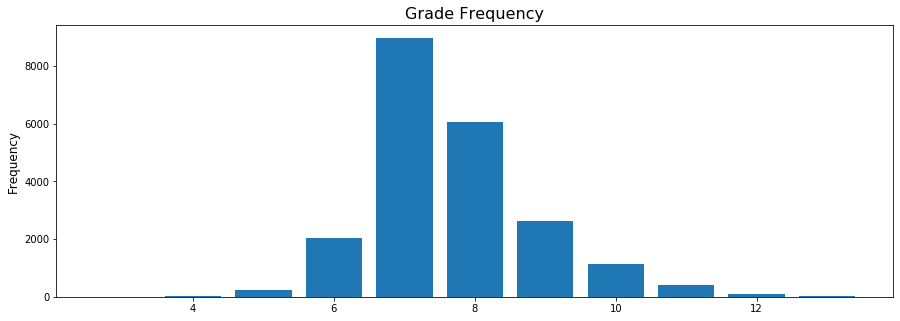

In [260]:
# Grade Frequency
fig, ax = plt.subplots(figsize = (15,5))
ax.bar(df["grade"].value_counts().index,
        df["grade"].value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Grade Frequency", size = 16)

df['grade'].sort_values().unique()


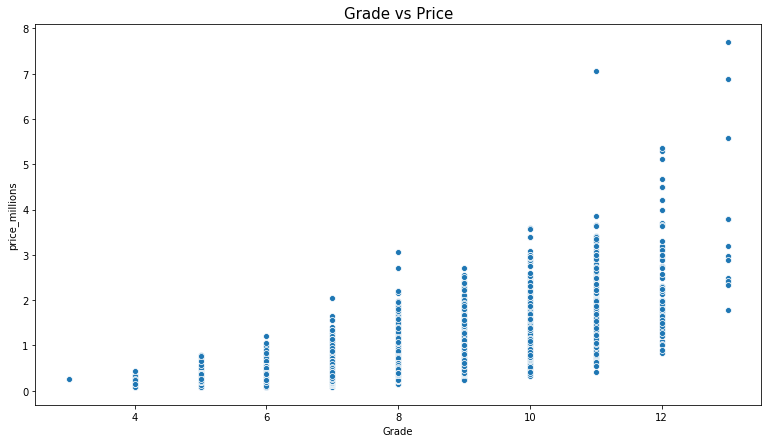

In [224]:
fig, ax = plt.subplots(figsize = (13,7))
sn.scatterplot(data = df, x = "grade", y = "price_millions")
ax.set_title('Grade vs Price', fontsize=15.0)
ax.set_xlabel('Grade', fontsize=10.0)
ax.ticklabel_format(style='sci', axis='x', scilimits=(1,1))
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

### Condition

array([1, 2, 3, 4, 5])

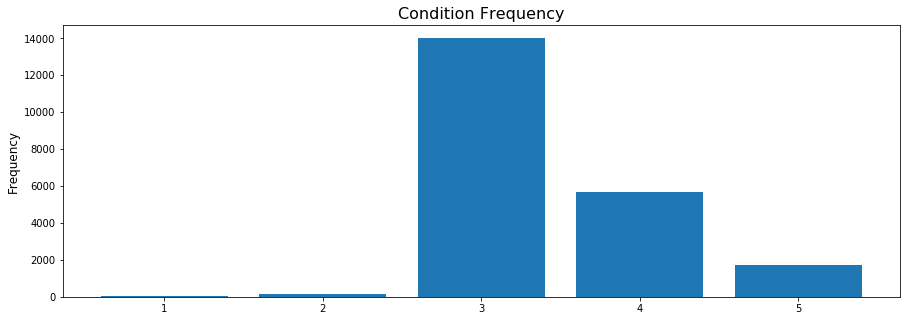

In [259]:
# Condition Frequency
fig, ax = plt.subplots(figsize = (15,5))
ax.bar(df["condition"].value_counts().index,
        df["condition"].value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Condition Frequency", size = 16)

df['condition'].sort_values().unique()

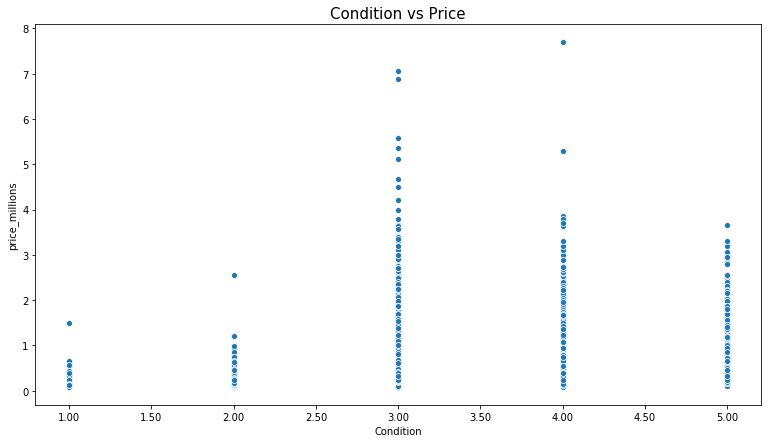

In [235]:
fig, ax = plt.subplots(figsize = (13,7))
sn.scatterplot(data = df, x = "condition", y = "price_millions")
ax.set_title('Condition vs Price', fontsize=15.0)
ax.set_xlabel('Condition', fontsize=10.0)
ax.ticklabel_format(style='sci', axis='x', scilimits=(1,1))
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))


### Floors

array([1. , 1.5, 2. , 2.5, 3. , 3.5])

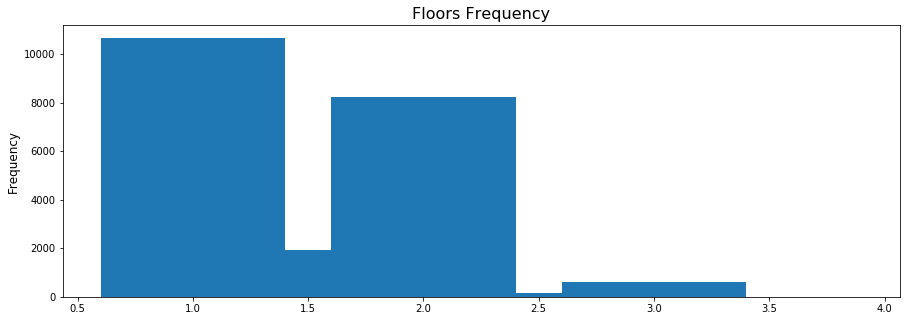

In [258]:
# Floors Frequency
fig, ax = plt.subplots(figsize = (15,5))
ax.bar(df["floors"].value_counts().index,
        df["floors"].value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Floors Frequency", size = 16)

df['floors'].sort_values().unique()

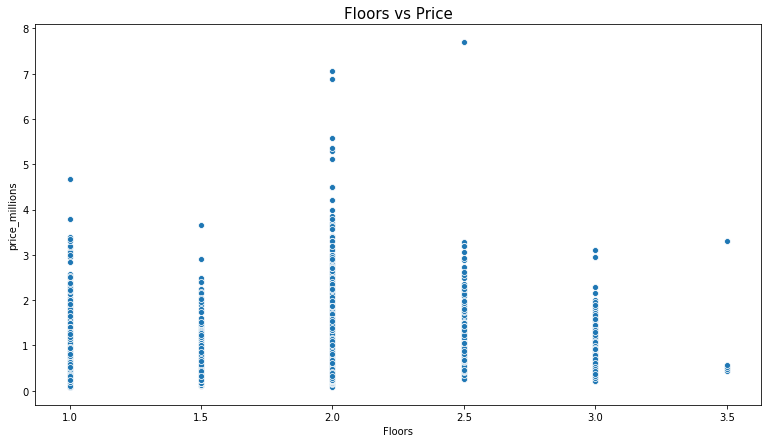

In [228]:
fig, ax = plt.subplots(figsize = (13,7))
sn.scatterplot(data = df, x = df["floors"], y = "price_millions")
ax.set_title('Floors vs Price', fontsize=15.0)
ax.set_xlabel('Floors', fontsize=10.0)
ax.ticklabel_format(style='sci', axis='x', scilimits=(1,1))
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

### Bedrooms

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 33])

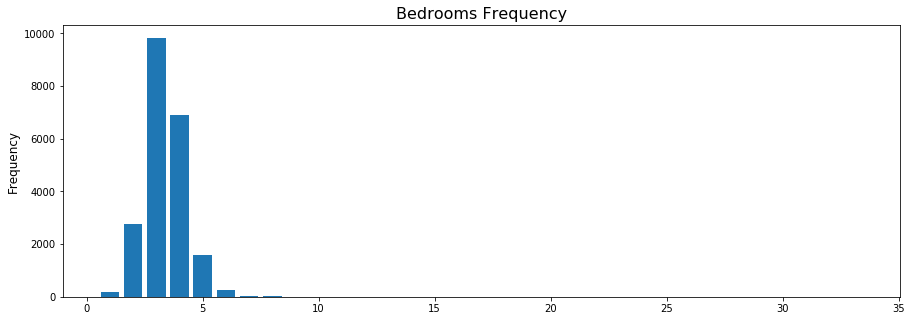

In [257]:
# Bedrooms Frequency
fig, ax = plt.subplots(figsize = (15,5))
ax.bar(df["bedrooms"].value_counts().index,
        df["bedrooms"].value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Bedrooms Frequency", size = 16)

df['bedrooms'].sort_values().unique()

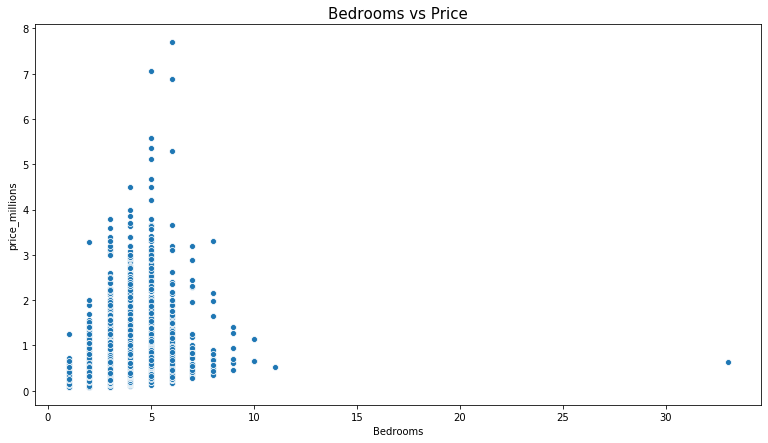

In [230]:
fig, ax = plt.subplots(figsize = (13,7))
sn.scatterplot(data = df, x = df["bedrooms"], y = "price_millions")
ax.set_title('Bedrooms vs Price', fontsize=15.0)
ax.set_xlabel('Bedrooms', fontsize=10.0)
ax.ticklabel_format(style='sci', axis='x', scilimits=(1,1))
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

### Bathrooms

array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75,
       6.  , 6.25, 6.5 , 6.75, 7.5 , 7.75, 8.  ])

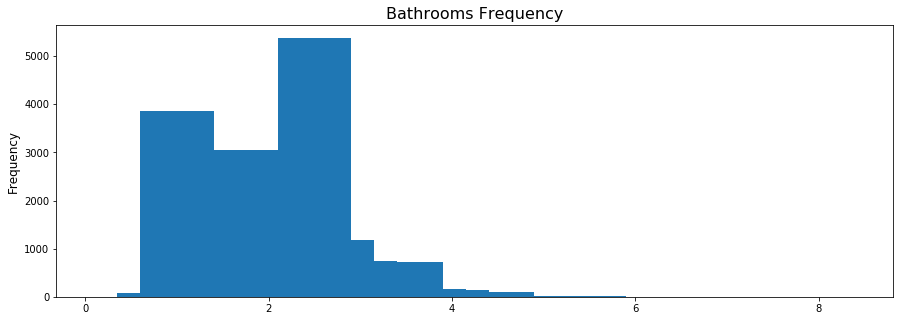

In [236]:
# Bathrooms Frequency
fig, ax = plt.subplots(figsize = (15,5))
ax.bar(df["bathrooms"].value_counts().index,
        df["bathrooms"].value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Bathrooms Frequency", size = 16)

df['bathrooms'].sort_values().unique()

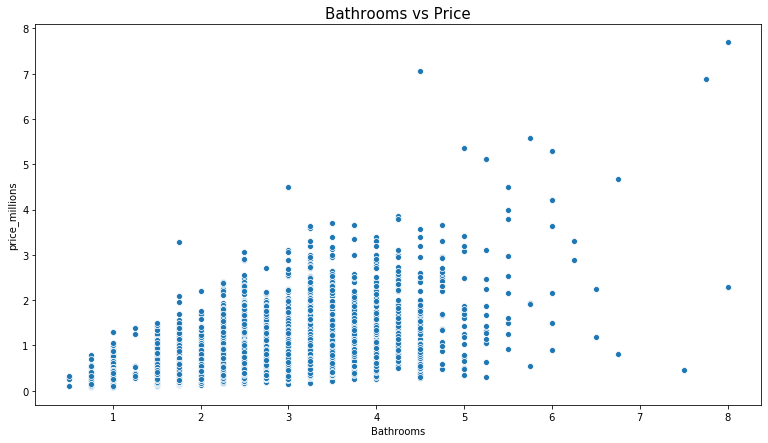

In [239]:
fig, ax = plt.subplots(figsize = (13,7))
sn.scatterplot(data = df, x = df["bathrooms"], y = "price_millions")
ax.set_title('Bathrooms vs Price', fontsize=15.0)
ax.set_xlabel('Bathrooms', fontsize=10.0)
ax.ticklabel_format(style='sci', axis='x', scilimits=(1,1))
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

### City

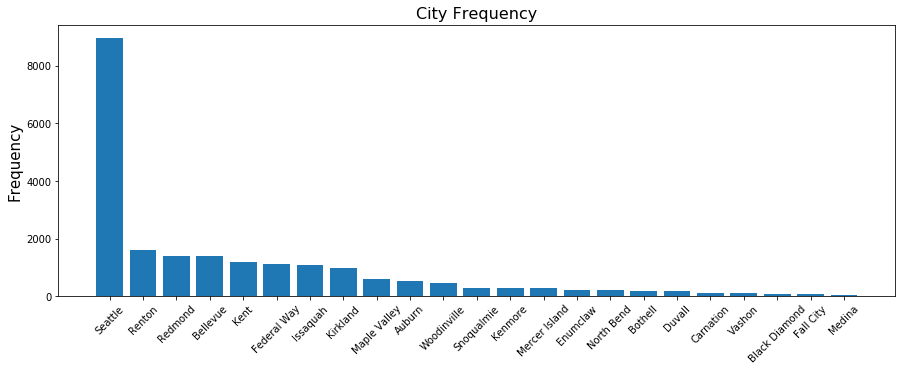

array(['Auburn', 'Bellevue', 'Black Diamond', 'Bothell', 'Carnation',
       'Duvall', 'Enumclaw', 'Fall City', 'Federal Way', 'Issaquah',
       'Kenmore', 'Kent', 'Kirkland', 'Maple Valley', 'Medina',
       'Mercer Island', 'North Bend', 'Redmond', 'Renton', 'Seattle',
       'Snoqualmie', 'Vashon', 'Woodinville'], dtype=object)

In [256]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.bar(df["city"].value_counts().index,
        df["city"].value_counts().values)
ax.set_ylabel("Frequency", size = 15)
ax.set_title("City Frequency", size = 16)
plt.xticks(rotation=45)
plt.show()
df['city'].sort_values().unique()

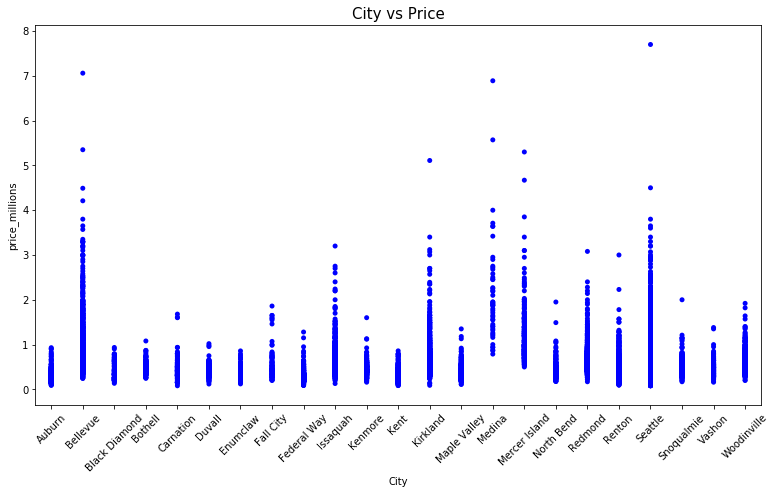

In [253]:
fig, ax = plt.subplots(figsize = (13,7))
sns.stripplot(data = df,
              x=df["city"], y="price_millions", 
              order = df["city"].sort_values().unique().tolist(),
              color = 'blue', jitter=False)
ax.set_title('City vs Price', fontsize=15.0)
ax.set_xlabel('City', fontsize=10.0)
plt.xticks(rotation=45)
plt.show()

### Day of Week Sold

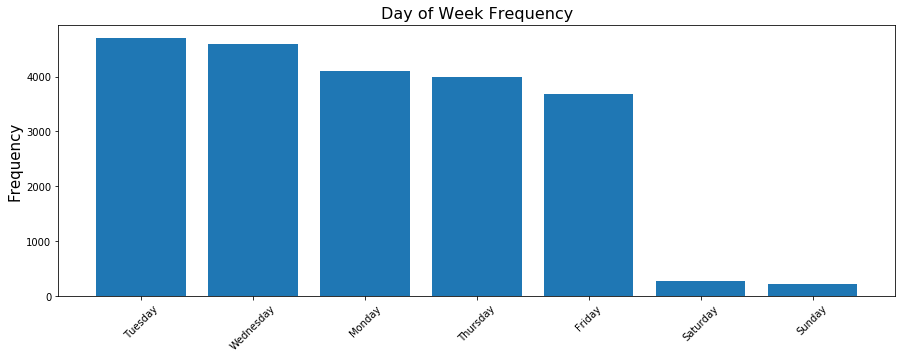

array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object)

In [265]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.bar(df["day_of_week_sold"].value_counts().index,
        df["day_of_week_sold"].value_counts().values)
ax.set_ylabel("Frequency", size = 15)
ax.set_title("Day of Week Frequency", size = 16)
plt.xticks(rotation=45)
plt.show()
df['day_of_week_sold'].sort_values().unique()


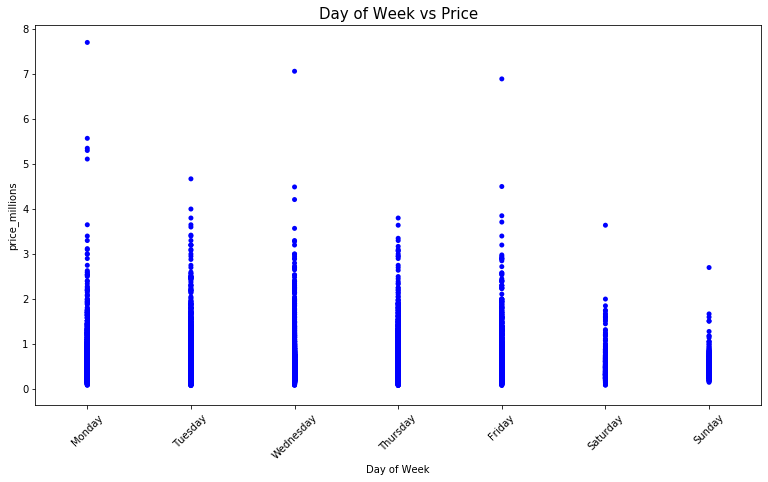

In [264]:
fig, ax = plt.subplots(figsize = (13,7))
sns.stripplot(data = df,
              x=df["day_of_week_sold"], y="price_millions", 
              order = df[["day_of_week_sold", "day_of_week_index"]].sort_values(by='day_of_week_index', ascending=True)['day_of_week_sold'].unique().tolist(),
              color = 'blue', jitter=False)
ax.set_title('Day of Week vs Price', fontsize=15.0)
ax.set_xlabel('Day of Week', fontsize=10.0)
plt.xticks(rotation=45)
plt.show()

### Season

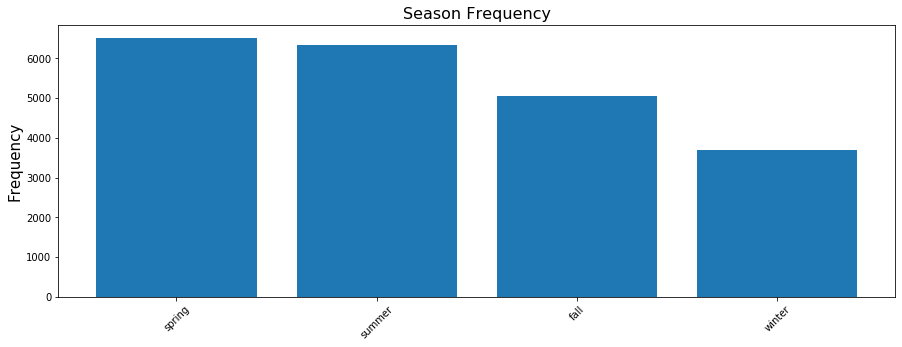

array(['fall', 'spring', 'summer', 'winter'], dtype=object)

In [267]:
# Season Sold Frequency
fig, ax = plt.subplots(figsize = (15, 5))
ax.bar(df["season_sold"].value_counts().index,
        df["season_sold"].value_counts().values)
ax.set_ylabel("Frequency", size = 15)
ax.set_title("Season Frequency", size = 16)
plt.xticks(rotation=45)
plt.show()
df['season_sold'].sort_values().unique()

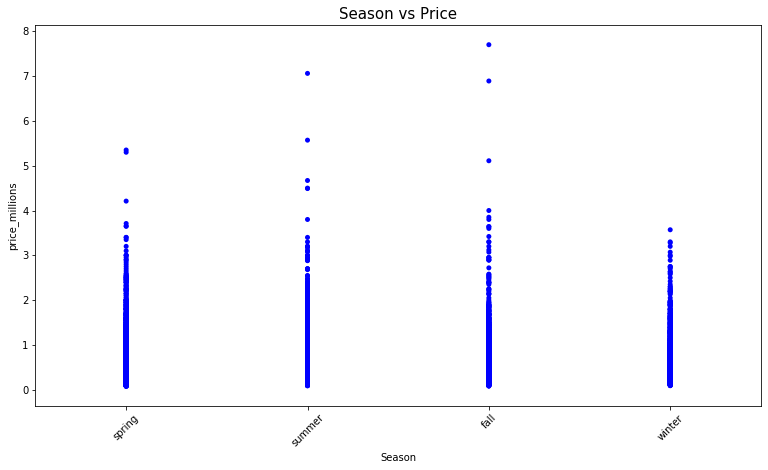

In [268]:
fig, ax = plt.subplots(figsize = (13,7))
sns.stripplot(data = df,
              x=df["season_sold"], y="price_millions", 
              order = df[["season_sold", "season_index"]].sort_values(by='season_index', ascending=True)['season_sold'].unique().tolist(),
              color = 'blue', jitter=False)
ax.set_title('Season vs Price', fontsize=15.0)
ax.set_xlabel('Season', fontsize=10.0)
plt.xticks(rotation=45)
plt.show()

### Month

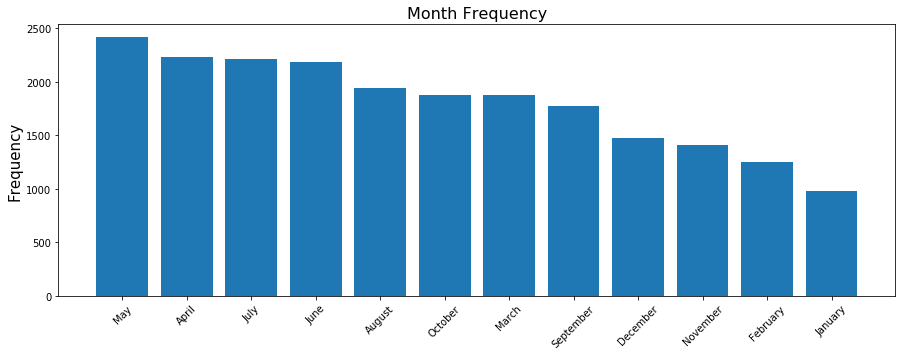

array(['April', 'August', 'December', 'February', 'January', 'July',
       'June', 'March', 'May', 'November', 'October', 'September'],
      dtype=object)

In [269]:
# Month Sold Frequency
fig, ax = plt.subplots(figsize = (15, 5))
ax.bar(df["month_sold"].value_counts().index,
        df["month_sold"].value_counts().values)
ax.set_ylabel("Frequency", size = 15)
ax.set_title("Month Frequency", size = 16)
plt.xticks(rotation=45)
plt.show()
df['month_sold'].sort_values().unique()

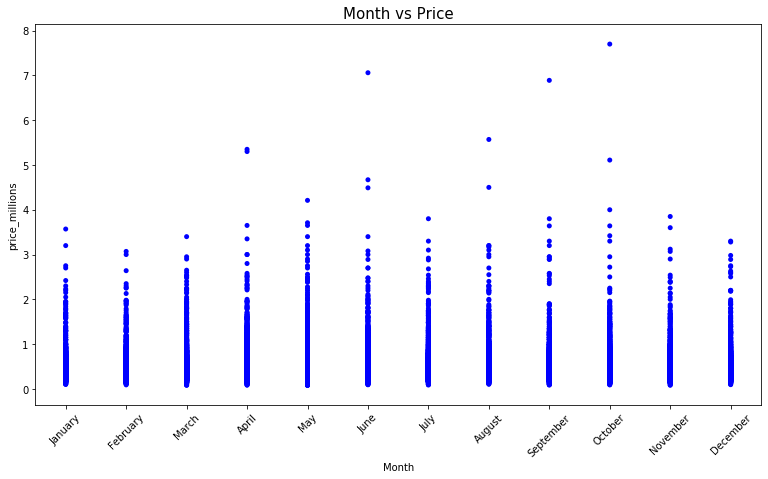

In [270]:
fig, ax = plt.subplots(figsize = (13,7))
sns.stripplot(data = df,
              x=df["month_sold"], y="price_millions", 
              order = df[["month_sold", "month_index"]].sort_values(by='month_index', ascending=True)['month_sold'].unique().tolist(),
              color = 'blue', jitter=False)
ax.set_title('Month vs Price', fontsize=15.0)
ax.set_xlabel('Month', fontsize=10.0)
plt.xticks(rotation=45)
plt.show()

### Age

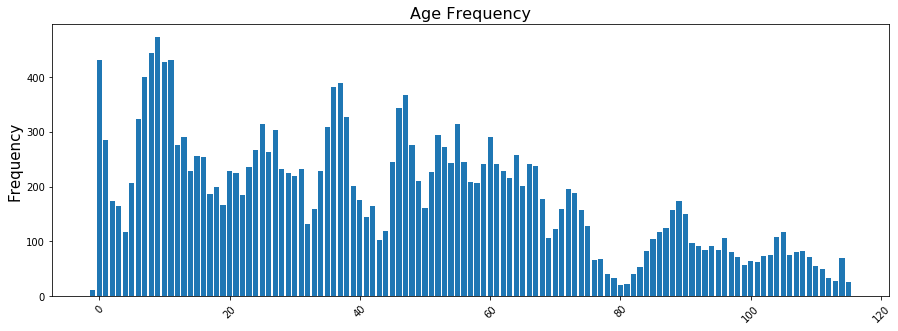

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115])

In [271]:
# Age of Home when Sold Frequency
fig, ax = plt.subplots(figsize = (15, 5))
ax.bar(df["age_sold"].value_counts().index,
        df["age_sold"].value_counts().values)
ax.set_ylabel("Frequency", size = 15)
ax.set_title("Age Frequency", size = 16)
plt.xticks(rotation=45)
plt.show()
df['age_sold'].sort_values().unique()

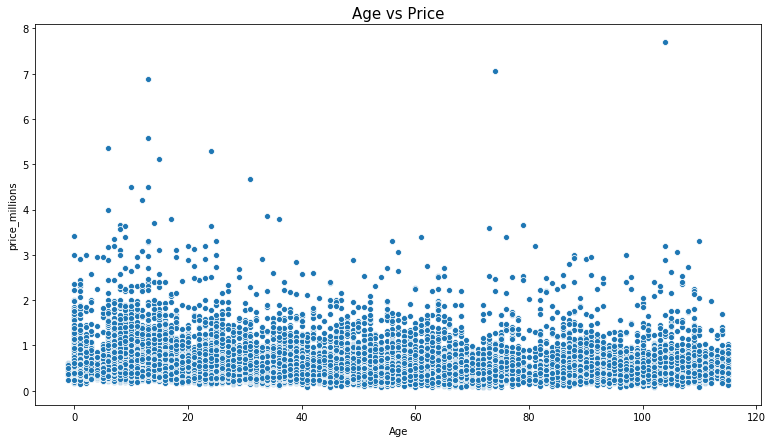

In [272]:
fig, ax = plt.subplots(figsize = (13,7))
sn.scatterplot(data = df, x = df["age_sold"], y = "price_millions")
ax.set_title('Age vs Price', fontsize=15.0)
ax.set_xlabel('Age', fontsize=10.0)
ax.ticklabel_format(style='sci', axis='x', scilimits=(1,1))
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

## Describe Data - Descriptive Statistics

In [ ]:
print(f"The max price is {df['price_millions'].max()} million, min price is {df['price'].min()}")

In [ ]:
#Markdown Version of Below Table:
#df_markdown = df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']].describe()
#print(df_markdown.to_markdown())

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built',
       'zipcode', 'lat', 'long'],
      dtype='object')

In [ ]:
format_dict = {'price': '{:20,.0f}', 'bedrooms': '{:.2f}', 'bathrooms': '{:.2f}', 'sqft_living': '{:20,.2f}', 'acres_lot': '{:.2f}', 'floors': '{:.2f}', 'waterfront': '{:.5f}',
'condition': '{:.2f}', 'grade': '{:.2f}', 'age_sold': '{:.0f}', 'yr_built': '{:.0f}', 'date': '{:.0f}'}
df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot', 'floors',
    'waterfront', 'condition', 'grade', 'age_sold', 'date', 'yr_built']].describe().style.format(format_dict)

#### Interpret .describe() 
- There are no negative values for any of the columns except age_sold
- The year range makes sense: homes were built between 1900 and 2015
- sqft_living average is around 2,000, which is close to the US average
- The average lot size is 15,099 square feet, or .35 acres
- The lot size mean is skewed by our outlier home, which stands on a 37.91 acre lot.
- The median sqft_lot size is 7,618 or .17 acres, which is much closer to the national average of 0.188 of an acre.
- Condition and Grade: The mean, max, and min all line-up with the scale of the system, described above.
    - Mean Grade is 7.66, so between a 7 and 8: 
        - 7. Average grade of construction and design. Commonly seen in plats and older sub-divisions.
        - 8. Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
    - Mean Condition is 3.41, closest to a 3: 
        - 3. Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

### Price Frequency Histogram

In [ ]:
# Price Frequency Histogram before removing outliers, for context:
# Here we can see that the distribution of price, our target variable, has considerable right-skew
ax = df.hist(column='price_millions',
             bins='auto',
             grid=False,
             figsize=(8,5))

ax = ax[0]
for x in ax:

    x.set_title("Distribution of Home Sale Price", size=20)

    # Set x-axis label
    x.set_xlabel("Sale Price of Home", labelpad=15, weight='bold', size=10)
    x.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}' + ' Million'))

    # Set y-axis label
    x.set_ylabel("Number of Homes Sold", labelpad=15, weight='bold', size=10)
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


## Price Density Histogram

In [ ]:
# Ok. Now let's draw a smooth curve, given the above data, using KDE (kernal density estimation)
# The smooth line in the visualization below is an estimate of the distributions of house prices
# The parameter bandwidth rules the smoothness of the underlying distribution

# The problem with a Probability Density Function plot, is that all "point probabilities" are 0
# We must calculate the area under the curve for an interval to get the actual probability that a home selling price is in a given range. 
# Thus, it's not intuitive or easy to "read" the y-axis to get probabilities for continuous variables using a PDF like below.

plt.figure(figsize = (12,8))
sns.distplot(df.price_millions,kde=True)
plt.title('Density Histogram of Housing Prices in Kings County')
plt.show()

For example, if we wanted to know the probability that a house price is between 1.00 and 1.75 million dollars (inclusive), we would use the following formula to take the integral of this range (AKA area under the curve)
$$\large P(1 \leq X \leq 1.75) = \int_{1}^{1.75} f_x(x) dx \geq 0 $$


### Narrow dataset for modeling 

In [ ]:
# Remember all columns in df are: 
df.columns.sort_values()

In [ ]:
# Select a subset of columns to create matrix:
df_all_cols = df.drop(['acres_lot','id'], axis=1)

In [ ]:
df_all_cols.columns.sort_values()

# DATA PREPARATION
- Prepping to model and addressing missing values -- completed in previous section "Data Quality"
- Convert categorical data to numeric via one-hot encoding (we didn't need to do this because everything is numeric and ordinal)
- Type conversions (this was done in the previous section - price to millions and sqft to acres)
- Remove multicollinearity (correlated predictors)
- Standardize numeric data -- We're not going to standardize our independent variables using z-score normalization because it's not necessary unless we're using logistic regression. 


## Explore Multicollinearity
- This a phenemonen where two variables we are using as predictors are correlated with each other
- This violates one of the assumptions of performing linear regression - that all independent variables are independent from one another
- If we left all features in the model without addressing multicollinearity, it would become very hard for the model to estimate the relationship between independent variables and the dependent variable, because rather than change independently, the features would change in pairs or groups.

In [ ]:
correlations = df_all_cols.drop(['price_millions'],axis = 1).corr()

In [ ]:
plt.figure(figsize=(12,12)) # Set size of figure
# Use df.corr() as your matrix for the heatmap
# I set the color scheme to green using cmap
# annot= True adds the float value on each square
# fmt='.1f' sets the number of decimal places for each float number. If you want 1.00, for example, use fmt='.2f'
# cbar_kws={"shrink": .77}  - this argument shrinks the side color bar to .77 of its original size
# square=True - this argument makes the figure square
ax = sns.heatmap(correlations, cmap = "Greens", annot=True, fmt='.2f', cbar_kws={"shrink": .77}, square=True)
# Sets the title
ax.set(title='King County House Sales Dataset Correlation Heatmap')
# Get the y-axis limit values for the size of the figure:
bottom, top = ax.get_ylim()
# Add .5 to the bottom and top of the y-axis limits to fix an error where the top and bottom squares are cut off
# This is an error for the versions of Seaborne and Matplotlib I'm using
ax = ax.set_ylim(bottom + 0.5, top - 0.5)
# Rotate the bottom labels by 30 degrees (100-70)
plt.xticks(rotation=70)
plt.show()


In [ ]:
correlations['price'].sort_values(ascending=False)

In [ ]:
correlations["sqft_living"].sort_values(ascending=False)

### Correlations Interpretation 
- Features highly correlated with price are sqft_living, grade, and bathrooms
- Features highly correlated with sqft_living are grade, bathrooms, price_millions, and bedrooms

## Address Multicollinearity
- First, review the columns and shape of the dataframe we will be using -- "df_all_cols"
- Next, use Variance Inflation Factor to detect high multicollinearity in our set of independent variables

In [ ]:
df_all_cols.columns

In [ ]:
df_all_cols.shape

In [ ]:
# We want to write a simple loop to use statsmodel's variance_inflation_factor method on each array (row) of our dataframe, for each column 
# That's why we use X.shape[1] as the range in the loop below, since the second term in the output of the .shape method is the number of columns
X = sm.add_constant(df_all_cols.drop(['price','price_millions'], axis=1))
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

### sqft_living has a moderately high VIF value, followed by grade
- We can try removing sqft_living or grade to see if it improves our R-squared and Root Mean Squared Error values.

# df_all_cols - Linear Regression
- Tune models to get the highest performance possible on our task
  - Considerations:
    - What kind of task? Classification task? Regression task?
      - This will be a regression task
    - Which models will we use
      - Linear Regression
    - Will be use regularization?
      - Out of scope for this exercise
    - How will we validate our model?
      - R-squared, Mean Squared Error, and the p-values of each coefficient.
    - Loss functions?
      - Out of scope for this exercise
    - What is the performance threshold for success?
      - We want to make sure to satisfy the assumptions of linear regression, and get a respectable R-squared value (at least .5)


## df_all_cols
- First we'll use statsmodels.api to run a linear regression and examine model validation scores.
- We'll use all the independent variables (df_all_cols) for now.

In [ ]:
df_all_cols.columns

In [ ]:
# Add constant (AKA y-intercept):
# The constant is set to 1 as default - with means that our constant coefficient will be equal to 1*Beta(0)
# Our other variables (other Betas) will be multiplied by a particular coefficient to predict price
X = sm.add_constant(df_all_cols.drop(['price','price_millions'], axis=1))
y = df_all_cols['price']
X.head()

In [ ]:
# The order of the parameters is: endogenous response variable(dependent variable), exogenous variables(independent variables)
model_all_cols = sm.OLS(y,X).fit()

In [ ]:
model_all_cols.summary()

In [ ]:
# In addition to R-Squared, we'll use Root Mean Squared Error to validate our model
# Here, our RMSE value is .047821 (million dollars) -- which heuristically can be thought of...
# ...as the normalized distance between our y values and our y-predicted values
# Thus, for any given prediction we make for a home price, we can expect to be about $47,821 off.
# Our model is failing to account for some important features underlying the data.
yhat = model_all_cols.predict(X)
model_rmse = np.sqrt(mean_squared_error(y, yhat))
model_rmse

## Test Linearity Assumption of Linear Regression
- By virtue of the method we are using to model our data, linear regression, we must satisfy the assumption that each of our explanatory variables exhibits a linear relationship with our dependent variable.
- In other words, we are assuming the following mathematical relationship between dependent variable y, and explanatory variables X:
$$
\begin{aligned}
	y &= mx + b \\
\end{aligned}
$$


In [ ]:
df_all_cols.columns.sort_values()

In [ ]:
# The first index is the number of rows and the second index is the number of cols. The third index is the position count of the figure layout

plt.subplots(figsize=(25, 25))
 

plt.subplot(5, 3, 1)
plt.scatter(df_all_cols['age_sold'], df_all_cols['price'])
plt.xlabel('Age Sold')
plt.ylabel('Price')

plt.subplot(5, 3, 2)
plt.scatter(df_all_cols['long'], df_all_cols['price'])
plt.xlabel('Longitude')
plt.ylabel('Price')

plt.subplot(5, 3, 3)
plt.scatter(df_all_cols['lat'], df_all_cols['price'])
plt.xlabel('Latitude')
plt.ylabel('Price')
 
plt.subplot(5, 3, 4)
plt.scatter(df_all_cols['zipcode'], df_all_cols['price'])
plt.xlabel('Zipcode')
plt.ylabel('Price')

plt.subplot(5, 3, 5)
plt.scatter(df_all_cols['yr_built'], df_all_cols['price'])
plt.xlabel('Year Built')
plt.ylabel('Price')
 
plt.subplot(5, 3, 6)
plt.scatter(df_all_cols['grade'], df_all_cols['price'])
plt.xlabel('Grade')
plt.ylabel('Price')

plt.subplot(5, 3, 7)
plt.scatter(df_all_cols['condition'], df_all_cols['price'])
plt.xlabel('Condition')
plt.ylabel('Price')
 
plt.subplot(5, 3, 8)
plt.scatter(df_all_cols['waterfront'], df_all_cols['price'])
plt.xlabel('Waterfront')
plt.ylabel('Price')

plt.subplot(5, 3, 9)
plt.scatter(df_all_cols['floors'], df_all_cols['price'])
plt.xlabel('Floors')
plt.ylabel('Price')
 
plt.subplot(5, 3, 10)
plt.scatter(df_all_cols['sqft_lot'], df_all_cols['price'])
plt.xlabel('Sqft Lot')
plt.ylabel('Price')

plt.subplot(5, 3, 11)
plt.scatter(df_all_cols['sqft_living'], df_all_cols['price'])
plt.xlabel('Sqft Living')
plt.ylabel('Price')
 
plt.subplot(5, 3, 12)
plt.scatter(df_all_cols['bedrooms'], df_all_cols['price'])
plt.xlabel('Bedrooms')
plt.ylabel('Price')

plt.subplot(5, 3, 13)
plt.scatter(df_all_cols['bathrooms'], df_all_cols['price'])
plt.xlabel('Bathrooms')
plt.ylabel('Price')
 
plt.subplot(5, 3, 14)
plt.scatter(df_all_cols['date'], df_all_cols['price'])
plt.xlabel('Year Sold')
plt.ylabel('Price')

plt.subplot(5, 3, 15)
plt.scatter(df_all_cols['price'], df_all_cols['price'])
plt.xlabel('Price')
plt.ylabel('Price')


# space between the plots
plt.tight_layout(4)
 
# show plot
plt.show()


## Notes on Scatterplots - Why we must One Hot Encode (specifically Dummy Variable Encode)
- For all scatterplots above where our datapoints appear in columns, rather than a continuous swath of points that overlap horizontally - we can see an important phenomenon that we've overlooked in the pre-processing steps "Understand Data" and "Data Preparation."
- Zipcode, Grade, Condition, Floors, Bedrooms, Bathrooms, Year Sold, and Waterfront are all categorical variables. That is, while there may be a natural ordering, as in a numerical range (.5-8 bathrooms), the data falls into distinct buckets. One way to think about categorical values is that the number of options is a fixed set. While the price of a home could be adjusted by any increment in dollar and cents amount, the number of bedrooms in a home is a variable that describes a "type" of home -- "1 bedroom mother-in-law cottage", "3-bedroom single family home", etc.
- For the purpose of this project I define a categorical variable as one where data falls into discrete bins, and where we can observe that comparing any given category ("4 bedrooms") - would be useful to regress against its opposite ("Not 4 bedrooms")
- Thus, we are going to one-hot encode all of our categorical variables using Dummy Variable Encoding - where we use i-1 columns to represent i different values for each categorical variable.
- We only need i-1 columns because the last value is Zero for all the rest of the columns.
- A simple example of this is Waterfront, which is already one-hot encoded - it's already an "Indicator Variable" which means the only possible values are True or False (We use 0 or 1)
- Thus for the variable "Waterfront" -- if the coefficient ends up being $200,000, that means the predicted price for waterfront homes will be y = 200,000(1) + intercept.
- In the case of non-waterfront homes, then, y = 200,000(0) + intercept, or y = intercept
- Our main task will be to think about which category should be dropped when we do Dummy Variable Encoding.
- Usually this dropped variable, AKA "baseline" is the value associated with the lowest target variable, or that which is associated with the average target variable.

Note:
Ultimately, if our model has a relatively low R-squared value (close to 50%), but we have:
1. fulfilled the assumptions of linear regression 
2. have normally distributed error 
3. coefficients have good p-values

... then we can still draw meaningful conclusions re: the relationships between the independent and dependent variables. Our coefficients will still represent the mean flucuation in the dependent variable for every 1-unit change in a given independent variable. 

## df_all_cols - Interpret
- Using all of our columns to predict price, and not subsetting the data at all:
- Our p-values are all 0.00, which is great.
- However, this model is violating necessary assumptions
    - The scatterplot of predicted price vs. price is clearly not a linear relationship
    - The plot of the residuals vs. the predicted price is trumpet-shaped, which is highly heteroscedastic.
    - What we are aiming for is linearity and homoscedasticity - a fairly even distribution of the residuals vs. predicted price

# Outliers Removed - Linear Regression
- Removing outliers can be a bit of an art, but given that my business case is to offer advice to mostly average, middle-class home owners, it makes sense to eliminate the priciest and lowest cost homes. 
- From the descriptive statistics we ran in the Understanding Data --> Distributions section, I surmised that the independent variables with the most unusual values were price and number of bedrooms. 

## Outliers Removed - statsmodels

In [ ]:
df_rm_outliers = df_all_cols.drop(['sqft_lot'], axis=1)

In [ ]:
# Here we take the absolute value of the z-scores for each value in columns "price" and "bedrooms" and filter our df by...
# ...only those values which have a z-score < 3

df_rm_outliers = df_rm_outliers[(np.abs(stats.zscore(df_rm_outliers[['bedrooms']])) < 2.5) & (np.abs(stats.zscore(df_rm_outliers[['price']])) < 2.5)]

In [ ]:
# Sort by Bedrooms:
df_rm_outliers[['price_millions', 'bedrooms', 'bathrooms']].sort_values('bedrooms', ascending = False).head(10)

In [ ]:
df_rm_outliers.columns

In [ ]:
#Markdown Version of Below Table:
#df_markdown_rm_outliers = df_rm_outliers[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']].describe()
#print(df_markdown_rm_outliers.to_markdown())

In [ ]:
# These values make a lot more sense
# The minimum and maximum values for price, bedrooms, and bathrooms are conceivable attributes of a middle class person's home.
# We didn't sacrifice on the size of our dataset, having only shed only about 4% of the number of rows in the original dataset.
format_dict = {'bedrooms': '{:.2f}', 'bathrooms': '{:.2f}', 'floors': '{:.2f}', 'sqft_living': '{:20,.2f}', 'sqft_lot': '{:20,.2f}',
               'price_millions': '{:,.8f}', 'yr_built': '{:.0f}', 'condition': '{:.2f}', 'grade': '{:.2f}', 'waterfront': '{:.5f}'}
df_rm_outliers[['price_millions', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
    'waterfront', 'condition', 'grade', 'yr_built']].describe().style.format(format_dict)

In [ ]:
# For our other variables (other Betas) will be multiplied by a particular coefficient to predict price
X = sm.add_constant(df_rm_outliers.drop(['price','price_millions'], axis=1))
y = df_rm_outliers['price']
X.head()

In [ ]:
model_rm_outliers = sm.OLS(y, X).fit() 

In [ ]:
model_rm_outliers.summary()

In [ ]:
# For any given prediction we make for a home price, we can expect to be about $25,790 off. 
yhat = model_rm_outliers.predict(X)
model_rmse = mean_squared_error(y,yhat)
model_rmse

## Outliers Removed  - interpret

- The R-squared value for model_log is 0.62
- Our p-values are all 0.00
- Model RMSE: For any given prediction we make for a home price, we can expect to be about $25,790 off
- Necessary assumptions for linear regression are better fulfilled than our last two iterations of linear regression modeling: 
    - The scatterplot of predicted price vs. price has a mostly linear shape
    - The plot of the residuals vs. the predicted price is almost evenly spread over the horizontal axis

Dropping sqft_lot and removing outliers based on the value of the z-scores for each value in columns "price" and "bedrooms" has improved our results compared to our last two iterations. Based on our p-values, R-squared value, and RMSE, as well as our assumptions of linear regression, we can be reasonably confident that we can interpret our coefficients as giving us the price increase of our home for every unit increase of the variable.
My real estate company can therefore advise clients that they should install a roof deck if it would add a waterfront view, as well as increase the quality of any improvements in their home, using this scale as their guide to quality craftmanship:
9. Better architectural design with extra interior and exterior design and quality.

10. Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11. Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12. Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13. Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.
